In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import osmnx as ox
import networkx as nx
import geopandas as gpd
import random
import pandas as pd
import pickle
import os
import pyproj
from shapely.geometry import Point, LineString
from datetime import datetime, timedelta
import ast
from geopy.distance import geodesic
from polyline import decode as decode_polyline
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from datetime import date

today_date = date.today()
prior_day = today_date - timedelta(days=1)

In [2]:
df_ml = pd.read_csv('C:\\Users\\Camelia\\Desktop\\app\\Disertatie\\ML\\MLDatasetUntil_'+prior_day.strftime("%Y-%m-%d")+'.csv')

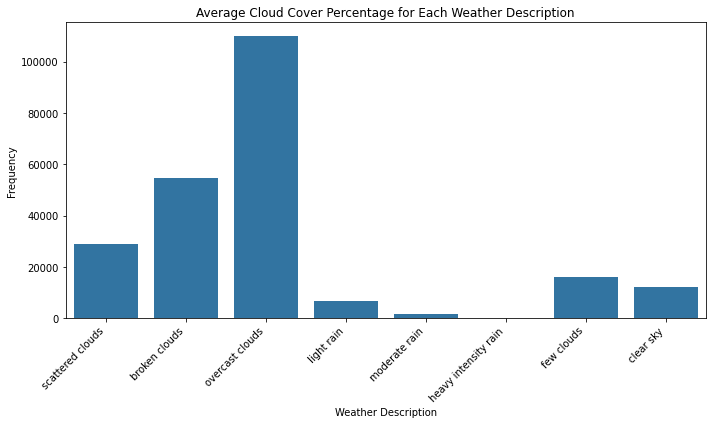

In [3]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_ml, x='weather_data')
plt.title('Average Cloud Cover Percentage for Each Weather Description')
plt.xlabel('Weather Description')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

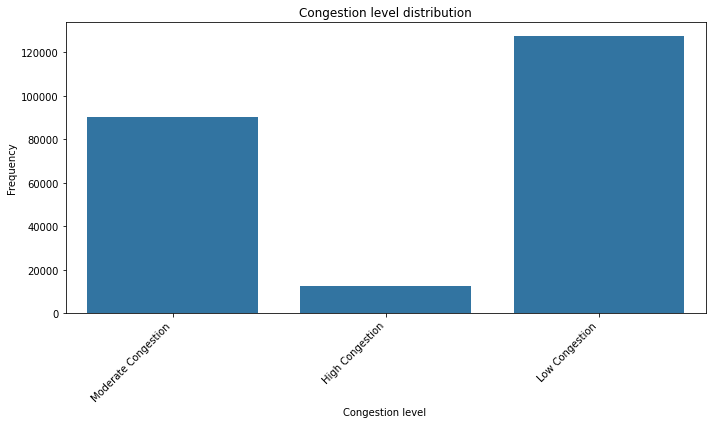

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_ml, x='congestion_level')
plt.title('Congestion level distribution')
plt.xlabel('Congestion level ')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
df_merged = pd.read_csv('C:\\Users\\Camelia\\Desktop\\app\\Disertatie\\GeneticAlg\\MergedUntil_'+prior_day.strftime("%Y-%m-%d")+'.csv')

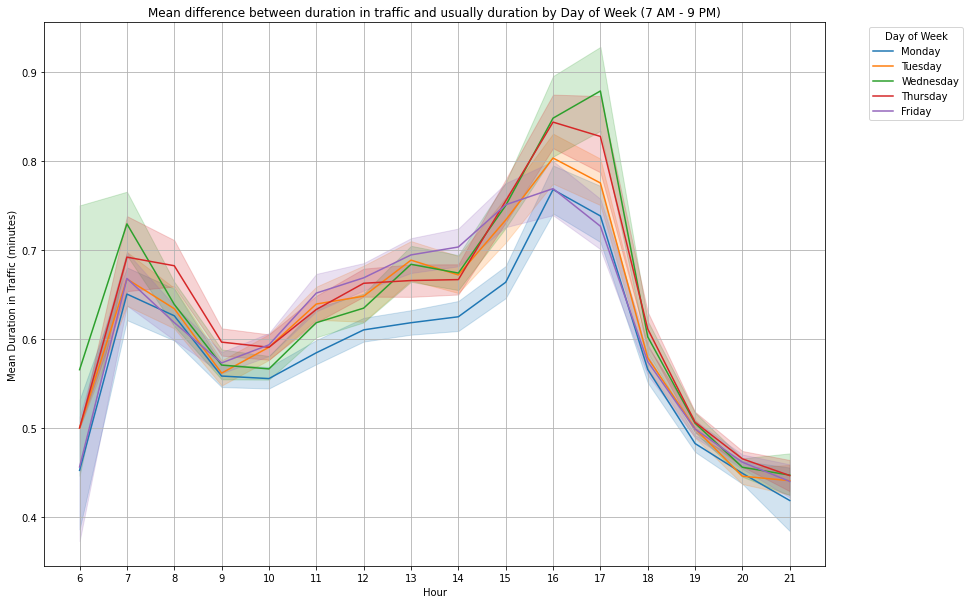

In [6]:
df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'],errors='coerce')
df_merged['hour'] = df_merged['timestamp'].dt.hour
df_merged['day_of_week'] = df_merged['timestamp'].dt.dayofweek
df_merged['duration_in_traffic_numeric'] = df_merged['duration_in_traffic'].str.extract('(\d+)').astype(int)
df_merged['duration_text_numeric'] = df_merged['duration_text'].str.extract('(\d+)').astype(int)
# Normalize congestion ratio using Min-Max normalization
df_merged['congestion_ratio'] = ((df_merged['duration_in_traffic_numeric'] - df_merged['duration_text_numeric']) / df_merged['duration_text_numeric'])

min_ratio = df_merged['congestion_ratio'].min()
max_ratio = df_merged['congestion_ratio'].max()
#df_merged['normalized_congestion'] = (df_merged['congestion_ratio'] - min_ratio) / (max_ratio - min_ratio)
df_merged['normalized_congestion']  = df_merged['congestion_ratio'] + abs(df_merged['congestion_ratio'].min())
# Filter data for weekdays and evening hours
filtered_data = df_merged[(df_merged['hour'].between(6, 22)) & (df_merged['timestamp'].dt.dayofweek < 5)].copy()
hourly_congestion = filtered_data.groupby(['origin_osmid','destination_osmid', 'hour','day_of_week'])['normalized_congestion'].mean().reset_index()
hourly_congestion['day_of_week'] = hourly_congestion['day_of_week'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'})
# Define the desired order of days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
# Plot data using Seaborn
plt.figure(figsize=(14, 10))
sns.lineplot(data=hourly_congestion, x='hour', y='normalized_congestion', hue='day_of_week', hue_order=day_order)
plt.title('Mean difference between duration in traffic and usually duration by Day of Week (7 AM - 9 PM)')
plt.xlabel('Hour')
plt.ylabel('Mean Duration in Traffic (minutes)')
plt.grid(True)
#plt.axhline(0, color='gray', linestyle='--')  # Add horizontal line at y=0
plt.xticks(range(6, 22))  # Set x-axis ticks from 7 PM to 9 PM
#plt.ylim(0.35, 2)  # Set y-limits from 0 to 1
plt.legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


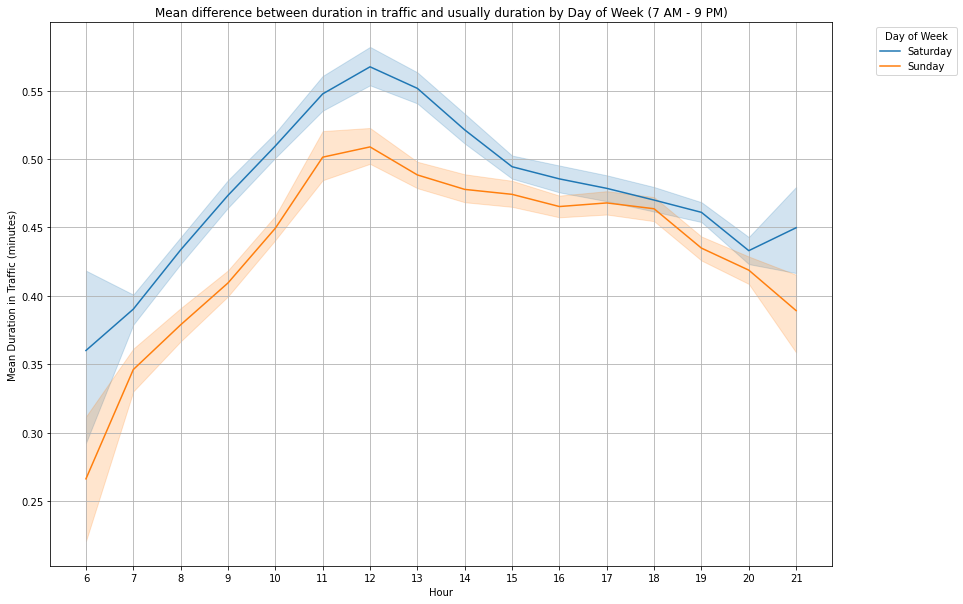

In [7]:
# ilter data for weekdays and evening hours
filtered_data = df_merged[(df_merged['hour'].between(6, 21)) & (df_merged['timestamp'].dt.dayofweek >= 5)].copy()
# Time-based aggregation
hourly_congestion = filtered_data.groupby(['origin_osmid','destination_osmid', 'hour','day_of_week'])['normalized_congestion'].mean().reset_index()
hourly_congestion['day_of_week'] = hourly_congestion['day_of_week'].map({5: 'Saturday', 6: 'Sunday'})
# Define the desired order of days of the week
day_order = ['Saturday', 'Sunday']
#######################################################################
plt.figure(figsize=(14, 10))
sns.lineplot(data=hourly_congestion, x='hour', y='normalized_congestion', hue='day_of_week', hue_order=day_order)
plt.title('Mean difference between duration in traffic and usually duration by Day of Week (7 AM - 9 PM)')
plt.xlabel('Hour')
plt.ylabel('Mean Duration in Traffic (minutes)')
plt.grid(True)
#plt.axhline(0, color='gray', linestyle='--')  # Add horizontal line at y=0
plt.xticks(range(6, 22))  # Set x-axis ticks from 7 PM to 9 PM
#plt.ylim(0.1, 0.3)  # Set y-limits from 0 to 1
plt.legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [8]:
def combine_levels(row):
    median = df_merged['normalized_congestion'].median()
    Q3 = df_merged['normalized_congestion'].quantile(0.75)
    IQR = Q3 - df_merged['normalized_congestion'].quantile(0.25)
    
    # Define congestion levels based on conditions
    if row['normalized_congestion'] <= median and row['intraffic_speed'] <= 25:
        congestion = 'Low'
    elif (median < row['normalized_congestion'] <= Q3 + 1.5 * IQR) and (25 < row['intraffic_speed'] <= 50):
        congestion = 'Moderate'
    elif (row['normalized_congestion'] > Q3 + 1.5 * IQR) and row['intraffic_speed'] > 50:
        congestion = 'High'
    else:
        congestion = 'Undefined'  # Handle any other cases

    return congestion

In [9]:
df_merged['duration_in_traffic_numeric'] = df_merged['duration_in_traffic'].str.extract('(\d+)').astype(int)
# 3. Compute average speed
# Adding a new column to the DataFrame for average speed
df_merged['intraffic_speed'] = 3.6*(df_merged['distance_value'] / (df_merged['duration_in_traffic_numeric']*60)) #in km/h
df_merged['average_speed'] = 3.6*(df_merged['distance_value'] / (df_merged['duration_value'])) #in km/h

speed_labels = ['Low Speed', 'Moderate Speed', 'High Speed']
speed_bins = [0, 25, 50, 150]  # You can adjust these bins based on your requirements
df_merged['speed_level'] = pd.cut(df_merged['intraffic_speed'], bins=speed_bins, labels=speed_labels)
# Apply the function to create the combined variable
df_merged['congestion_speed_level'] = df_merged.apply(combine_levels, axis=1)

In [10]:
df_merged['congestion_level']  =df_ml['congestion_level']

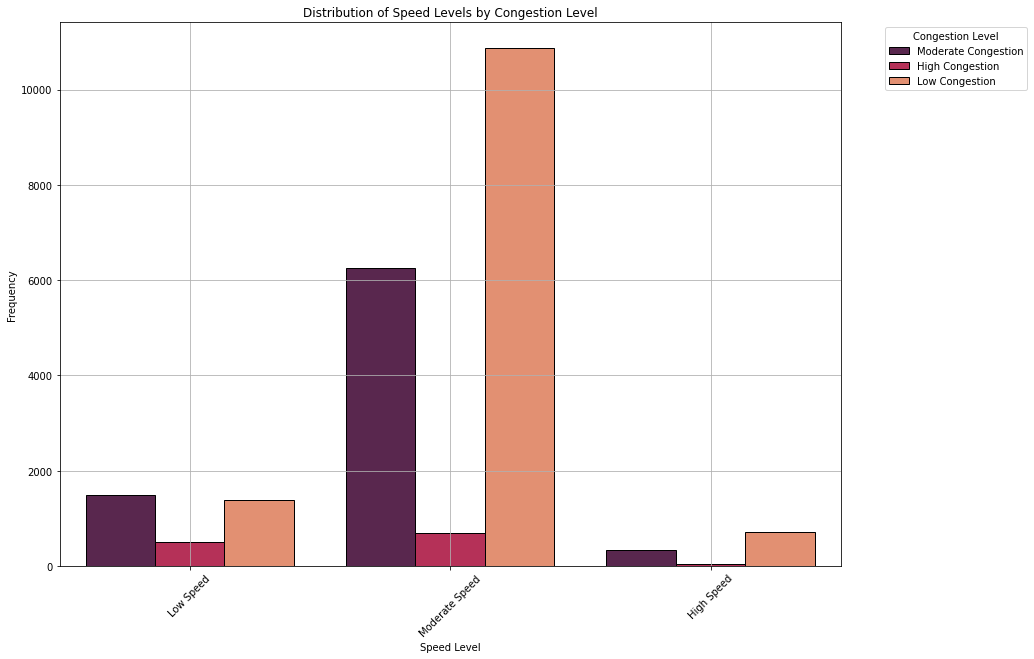

In [11]:
# Plot distribution of congestion levels
plt.figure(figsize=(14, 10))
sns.countplot(data=df_merged, x='speed_level', hue='congestion_level', order=speed_labels, palette='rocket', edgecolor='black')
plt.title('Distribution of Speed Levels by Congestion Level')
plt.xlabel('Speed Level')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Congestion Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()